## Running a bell circuit on different backends

In [1]:
!pip install qiskit-braket-provider==0.2.0

In [2]:
import numpy as np
import time

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from qiskit_braket_provider import BraketProvider
from qiskit_braket_provider.providers import adapter
from braket.aws import AwsSession

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator
from qiskit.circuit import ParameterVector, Parameter

import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from braket_estimator import BraketEstimator

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")
BraketProvider().backends()

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

In [3]:
batchsize = 50
n_shots = 10_000

#### Run with native Braket SV Backend

In [4]:
backend = BraketProvider().get_backend('SV1')

device = backend._device
device

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)

In [5]:
braket_bell_circ = Circuit().h(0).cnot(0, 1)
print(braket_bell_circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [6]:
start_time = time.time()
job_braket_native = device.run_batch(
    [braket_bell_circ] * batchsize,
    shots=n_shots,
)
job_braket_native.results()
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
print('Execution time per circuit:', round(run_batch_time / batchsize, 2), 'seconds')

--- 32.71 seconds ---
Execution time per circuit: 0.65 seconds


#### Run with Braket Provider + **Estimator Primitive**

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


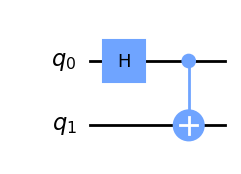

In [7]:
qiskit_bell_circ = QuantumCircuit(2)
qiskit_bell_circ.h(0)
qiskit_bell_circ.cx(0, 1)

qiskit_bell_circ.draw("mpl")

Before the improvement in downloading results from Estimator, the below cell took 532 secs to complete

In [8]:
backend = BraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
qiskit_observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))

qiskit_start_time = time.time()
job = estimator.run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
job.result().values # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per circuit:', round(qiskit_run_batch_time / (batchsize * 3), 2), 'seconds')

I0000 00:00:1710138413.609247       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 2.3561944901923457 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


--- 83.67 seconds ---
Execution time per circuit: 0.56 seconds


In [9]:
qiskit_expvals = job.result().values

#### Use ``Estimator`` from Qiskit

In [10]:
start_time = time.time()
job = Estimator().run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
qiskit_expvals_2 = job.result().values
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
# Three non-commuting parts of the Hamiltonian lead to three measured circuits per Hamiltonian
print('Execution time per circuit:', round(run_batch_time / (batchsize * 3), 2), 'seconds')

--- 0.03 seconds ---
Execution time per circuit: 0.0 seconds


In [11]:
qiskit_expvals_2 - qiskit_expvals

array([-0.00525878,  0.00543803, -0.00119444, -0.00161656,  0.00203959,
        0.00190078, -0.0023187 ,  0.00092939, -0.00334703,  0.0096579 ,
       -0.00748801,  0.00354296, -0.0088413 ,  0.00609355,  0.00303315,
        0.00049845,  0.00091414, -0.00495264,  0.01341821,  0.00408252,
        0.00534098,  0.00841487, -0.0028021 ,  0.00440317,  0.00016878,
        0.00276217, -0.00801259, -0.00196247,  0.00680259, -0.001227  ,
       -0.00168874,  0.00244386, -0.005714  ,  0.00152023,  0.00430649,
       -0.00026036, -0.00498654,  0.00145354, -0.00628134,  0.0029091 ,
       -0.00143538, -0.00142802,  0.00818742, -0.00512188, -0.00100402,
        0.00229352,  0.00779831,  0.00124121, -0.00339006,  0.00788146])

In [12]:
max(qiskit_expvals_2 - qiskit_expvals)

0.013418214612043733

#### Run Circuit and Measure observables on own ``BraketEstimator``

In [13]:
backend = LocalSimulator()
estimator = BraketEstimator(backend)

braket_observables = qiskit_observables.to_list()

In [14]:
start_time = time.time()
expvals = estimator.run(
    circuit=[braket_bell_circ] * batchsize,
    observables=[braket_observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    shots=n_shots
)
run_braket_estimator_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_braket_estimator_time, 2)))
print('Execution time per circuit:', round(run_braket_estimator_time / (batchsize * 3), 2), 'seconds')

--- 5.1 seconds ---
Execution time per circuit: 0.03 seconds


In [15]:
expvals.astype(float) - qiskit_expvals

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_35425/798129361.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  expvals.astype(float) - qiskit_expvals


array([-6.75e-03,  8.50e-04,  3.25e-03, -2.30e-03, -2.90e-03, -5.55e-03,
        2.50e-04, -2.40e-03, -7.00e-04, -3.50e-03,  1.80e-03,  1.60e-03,
       -7.05e-03,  7.50e-04,  4.20e-03, -3.80e-03, -4.60e-03, -4.75e-03,
        4.90e-03, -5.00e-05,  4.30e-03, -7.00e-03, -1.70e-03,  5.60e-03,
       -5.50e-03, -5.25e-03, -9.45e-03, -1.00e-03,  2.70e-03,  2.00e-03,
        4.55e-03,  9.75e-03, -2.95e-03,  3.55e-03,  6.90e-03,  3.50e-04,
       -2.85e-03, -1.85e-03, -2.50e-03, -3.00e-03, -3.90e-03, -5.10e-03,
       -9.50e-04, -4.65e-03,  2.60e-03,  4.10e-03,  2.80e-03,  4.95e-03,
        6.05e-03, -3.05e-03])

In [16]:
max(expvals.astype(float) - qiskit_expvals)

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_35425/3208180139.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  max(expvals.astype(float) - qiskit_expvals)


0.009750000000000147

#### Running batch of qiskit circuits with SV1 backend provider

In [18]:
backend = BraketProvider().get_backend('SV1')

In [19]:
qiskit_start_time = time.time()
job = backend.run(
    [qiskit_bell_circ] * batchsize,
    shots=n_shots
)
result = job.result() # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per batch:', round(qiskit_run_batch_time / batchsize, 2), 'seconds')

--- 29.77 seconds ---
Execution time per batch: 0.6 seconds
